In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML


#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
###########################################################
# Example n=5, k = 2

TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.08, 0.26, 0.9]
                                                   ])

TRUCK_MAX_LOADS = np.array([70.,130.])

GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 0.])
DISCRETE = True
############################################################



###########################################################
# Example n=9, k = 3

TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200., 500., 300., 800., 300.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.08, 0.26, 0.9],
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85]
                                                   ])

TRUCK_MAX_LOADS = np.array([70.,130.,250.])

GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 32., 159., 162., 156., 0.])
DISCRETE = True
############################################################


env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length



In [3]:
def int_to_action(int_action: int, env):
    """
    So far assumed k = 2 or 3:
    
    Converts an integer between 0 and env.action_space.shape[1]**env.action_space.shape[0]
    which is (n+1)^k where n is the number of tanks and k the number of trucks.
    
    return vect_action: a k-dimensional vector with components in the range 0,...n. 
    For k = 2, vect_action = [i,j] is the action of truck 1 going to tank i and truck 2 going to tank j.
    (i, j = n means staying at the depot, 0,....,n-1 are the real tanks).
    The associated integer is i*(n+1) + j
    
    For k = 3, vect_action = [i,j,l] is the action of truck 1 going to tank i, truck 2 going to tank j,
    and truck 3 going to tank l.
    (i, j, l = n means staying at the depot, 0,....,n-1 are the real tanks).
    The associated integer is (i*(n+1) + j)*(n+1) + l

    """
    nplus1 = env.action_space.shape[1]
    k = env.action_space.shape[0]
    n_actions = nplus1**k
    
    if k == 2:
        j = int_action % nplus1
        i = int((int_action-j)/nplus1)
        vect_action = np.array([i,j])
      
    elif k == 3:
        l = int_action % nplus1
        ij = int( (int_action - l)/nplus1 ) 
        j = ij % nplus1
        i = int((ij-j)/nplus1)
        vect_action = np.array([i,j,l])
    
    else:
        raise ValueError("The number of trucks k of the environment is different from 2 or 3")
    return vect_action

def action_to_int(vect_action: np.array, env):
    """
    Assumed k = 2 or 3, so vect_action has 2 or 3 components
    """
    nplus1 = env.action_space.shape[1]
    k = env.action_space.shape[0]
    if k == 2:
        int_action = vect_action[0] * nplus1 + vect_action[1]
    elif k == 3:
        int_action = (vect_action[0] * nplus1 + vect_action[1])*nplus1 + vect_action[2]
    else:
        raise ValueError("The number of trucks k of the environment is different from 2 or 3")

    return int_action
    

In [4]:
int_action = 66
print(int_action)
vect_action = int_to_action(int_action,env)
print(vect_action)
int_action = action_to_int(vect_action,env)
print(int_action)

66
[0 6 6]
66


In [5]:
reset_graph()

seed = 42
learning_rate = 0.01 #0.01

model_file = './final_pgmodel.ckpt'#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)
epochs = 100 #2000
batch_size = 50 #50

summary_freq = 100#np.ceil(epochs/10) #200


hidden1_neurons = 200 #100
hidden2_neurons = 100 #50


with tf.name_scope("dnn"):
            #inputs = tflearn.input_data(shape=[None, self.s_dim])
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            #indices = [i for i in range(n_outputs)]
            
            initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            #y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer)
            logits = tf.layers.dense(hidden2, n_outputs)#,kernel_initializer = initializer)
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            #print(tf.rank(action))
            #action_onehot = tf.one_hot(indices, n_outputs)
            #y = tf.reshape(action_onehot[action], (n_outputs, None))
            #y = tf.Variable(action, tf.int64)
            y = tf.reshape(action, [1])
            #print(tf.rank(y))
            #print(tf.rank(logits))
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
#             xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y,
#                                                                       logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            #optimize = optimizer.minimize(loss)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)

                        
# # with tf.name_scope("eval"):
# #             correct = tf.nn.in_top_k(logits, y, 1)
# #             accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# # tf.summary.scalar('accuracy', accuracy)

                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        
    

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
"""
From https://github.com/ageron/handson-ml 
"""

def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [ ]:
seed = 42
np.random.seed(seed)

best_acc_val = 0
acc_val = 0

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   

n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 500000
save_iterations = 500
discount_rate = 0.95

summary_freq = 100
avg_rewards_list = []

with tf.Session() as sess:
    #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)

    init.run()
    for iteration in range(n_iterations+1):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                obs, reward, done, info = env.step(vect_action)
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                
#                 error = sess.run(loss, feed_dict={                                        
#                                         X: obs.reshape(1, n_inputs)
#                                     })
                #print("Loss: ", "Reward: ", reward)
                #train_writer.add_summary(summary, iteration)
                
                
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        if iteration % summary_freq == 0:  
            avg_rewards = np.mean(np.array(all_rewards))
            avg_rewards_list.append(avg_rewards)
            
            print("Average reward per game: ",  avg_rewards / n_games_per_update)    

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
         
       
        #tf.summary.scalar('avg_rewards', avg_rewards)


        #train_writer.add_summary(avg_rewards, iteration)


        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
                  saver.save(sess, "./pdenv_policy_net_pg.ckpt")
    #train_writer.close()
# with tf.Session() as sess:
#         train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
#         val_writer = tf.summary.FileWriter(log_dir + '/val')
        
#         init.run()
#         N_TRAIN = X_train.shape[0]
#         m = y_train.shape[0]
        
#         n_batches = int(np.ceil(N_TRAIN/ batch_size))
#         #print(n_batches)
             
#         for epoch in range(epochs+1):
            
#             for batch_index in range(n_batches):
#                 X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
#                 #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
#                 sess.run(optimize, feed_dict={
#                                     y: y_batch,
#                                     X: X_batch
#                                 })
    
#             if summary_freq != None: 
                            
#                 if epoch % summary_freq  == 0:
                    

#                     summary, acc_train = sess.run([merged, accuracy], feed_dict={
#                                         y: y_batch,
#                                         X: X_batch
#                                     })
#                     train_writer.add_summary(summary, epoch)

#                     summary, acc_val = sess.run([merged, accuracy], feed_dict={
#                                         y: y_val,
#                                         X: X_val
#                                     }) 
                                    
#                     val_writer.add_summary(summary, epoch)

#                     best_acc_val = max(best_acc_val, acc_val)
#                     #print(acc_val, best_acc_val)

#                     print("Epoch: ", epoch, " Train (batch) accuracy: ", acc_train, 
#                           " Validation accuracy: ", acc_val)
#                     if best_acc_val <= acc_val:                        
#                         save_path = saver.save(sess, model_file)
#                         print("Saved model with validation accuracy ", acc_val)
#         train_writer.close()
#         val_writer.close()                            
#         #save_path = saver.save(sess, model_file)   
  

Iteration: 0Average reward per game:  -0.4335298798341383
Iteration: 100Average reward per game:  -0.4047363382936703
Iteration: 200Average reward per game:  -0.18600617214788873
Iteration: 300Average reward per game:  -0.2866465931994452
Iteration: 400Average reward per game:  -0.2005341709005402
Iteration: 500Average reward per game:  -0.2068082685573153
Iteration: 600Average reward per game:  -0.22022137331649017
Iteration: 700Average reward per game:  -0.21128324745346427
Iteration: 800Average reward per game:  -0.22354233621038042
Iteration: 900Average reward per game:  -0.17776624160874047
Iteration: 1000Average reward per game:  -0.18462908140319625
Iteration: 1100Average reward per game:  -0.1629676338212835
Iteration: 1200Average reward per game:  -0.18240910787736883
Iteration: 1300Average reward per game:  -0.17770918802100663
Iteration: 1400Average reward per game:  -0.23762774879651438
Iteration: 1500Average reward per game:  -0.18124559108800772
Iteration: 1600Average rew

In [ ]:
# Iteration: 0Average reward per game:  -131.21281576006612
# Iteration: 100Average reward per game:  -92.23713538883702
# Iteration: 200Average reward per game:  -70.92879872240424
# Iteration: 300Average reward per game:  -46.36746628903998
# Iteration: 400Average reward per game:  -43.44814607253152
# Iteration: 500Average reward per game:  -26.28340975064497
# Iteration: 600Average reward per game:  -24.65947230415822
# Iteration: 700Average reward per game:  -30.107651383652463
# Iteration: 800Average reward per game:  -17.534408167806813
# Iteration: 900Average reward per game:  -19.252239544660405
# Iteration: 1000Average reward per game:  -20.431260399119516

## PLAY:

In [10]:
seed = 45
np.random.seed(seed)

frames = []
n_episodes = 5

system = PDSystemEnv()

model_file = "pdenv_policy_net_pg.ckpt"

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
                #print(state)
                #print(action_val[0],emptiest_tank_policy(state, system))
        env.close()
    

INFO:tensorflow:Restoring parameters from pdenv_policy_net_pg.ckpt


In [11]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

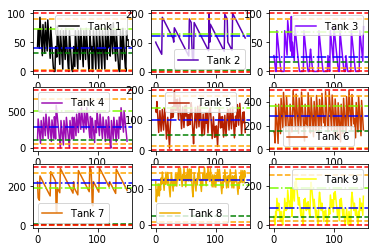

In [12]:
plt.close()

#THE REAL LEVELS (percentages 12h, 36h, ? h)
tank_levels = [frames[i][2] for i in range(len(frames))]
tank_levels_array = np.asarray(tank_levels).transpose()

n = system.n

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks_max_load = system.tank_max_loads
level_percentages = system.load_level_percentages

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
        plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = level_percentages[i-1]           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
    
    plt.legend(loc='best')
plt.show()


In [ ]:
int_to_action(352,env)